In [63]:
%run init_notebookspace.py

DATA_DIR is existant under: /Users/tsagedouglas/Data Science Project (Python Proj)/data


In [8]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 13.8 kB/s eta 0:00:00 0:00:08
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 32.7 kB/s eta 0:00:00a 0:00:01


In [10]:
!pip install pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 172.8 kB/s eta 0:00:00a 0:00:01


In [12]:
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 69.6 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 228.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 137.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 387.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 560.5 kB/s eta 0:00:00a 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=ff31f01de0411ce7da5cbb896eab94baa6e67eabc7cafd294b28feb118e949db
  Stored in directory: /Users/tsagedouglas/Library/Caches/pip/wheels/8b/ac/c5/cb646ab01df6f353a9994b1c97dffb94f9b12013d64c162c58
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24570 sha256=0c934f7799d7f920a408dc2396562dda1ab99a2a0ea58c3b85249f732dbd9e68
  Sto

In [13]:
import pandas as pd
import numpy as np

import yfinance as yf
import pandas_datareader as pdread
from pandas_datareader import fred

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from yahoo_fin import stock_info as ysi

from itertools import chain

In [14]:
from src.utils import apply_datetime_format

In [15]:
# get sp500 composits & market cap
sp500_tickers = ysi.tickers_sp500()
df = pd.DataFrame(index=sp500_tickers, 
                  columns=['market_cap'], 
                  data=[pdread.get_quote_yahoo(item)['marketCap'].values[0] for item in sp500_tickers])
sp500_largest = df.sort_values('market_cap', ascending=False).index[:5].values
sp500_ticker = ['^GSPC']

In [16]:
start = '2020-01-01'
end = '2022-12-31'

In [17]:
df_prices = pd.DataFrame()
df_prices.index = pd.date_range(start, periods=(apply_datetime_format(end, '%Y-%m-%d') - apply_datetime_format(start, '%Y-%m-%d')).days)

for item in [*chain(sp500_largest, sp500_ticker)]:
    data = yf.download(item, start, end)
    data.columns = list([f'{item}_{x}' for x in data.columns])
    df_prices = df_prices.join(data)
    
# get closing price
df_c = df_prices[[item for item in df_prices.columns if 'Adj Close' in item]].copy()
df_c.columns = [item[:-10] for item in df_c.columns]
df_c.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
# get log returns
df_rets = np.log(df_c / df_c.shift(1)).dropna()
df_rets.sort_index(inplace=True)
df_rets.asfreq = "D"

df_rets['^GSPC_lead'] = df_rets['^GSPC'].shift(1)

df_rets.dropna(inplace=True)
df_rets.index.asfreq = 'd'


In [64]:
# save data to file
df_rets.to_csv(os.path.join(DATA_DIR, 'returns.csv'))

In [88]:
# load data from file
df_rets = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'))

In [89]:
# Error Attempts 
# original : 
# mydata = pd.read_csv('mydataset.csv', names = ['value'], header = 0)  
# mydata = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'))  
    # But this is wrong because I need the 'value' argument 
#mydata = pd.read_csv('returns.csv', names = ['value'], header = 0)  
    # But this is wrong because it 'cannot find the file'
#mydata = pd.read_csv('returns.csv', names = ['0,AAPL,MSFT,GOOG,GOOGL,AMZN,^GSPC,^GSPC_lead'], header = 0)  
#mydata = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['0,AAPL,MSFT,GOOG,GOOGL,AMZN,^GSPC,^GSPC_lead'], header = 0)  


In [90]:
# Checking for stationarity via ADF test below
# dickey-fuller attempt 1 
from statsmodels.tsa.stattools import adfuller  
from numpy import log  
import pandas as pd  
  
mydata = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)  

res = adfuller(mydata.value.dropna())  
                     
print('Augmented Dickey-Fuller Statistic: %f' % res[0])  
print('p-value: %f' % res[1])  

Augmented Dickey-Fuller Statistic: -8.078260
p-value: 0.000000


In [91]:
# determining the ADF for the 'd' value of ARIMA 


In [111]:
# Next looking at autocorrelation 
import numpy as np, pandas as pd  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import matplotlib.pyplot as plt 
plt.rcParams.update({'figure.figsize' : (9,7), 'figure.dpi' : 120})
plt.show()

In [112]:
# Importing data  
df = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)  

ValueError: setting an array element with a sequence.

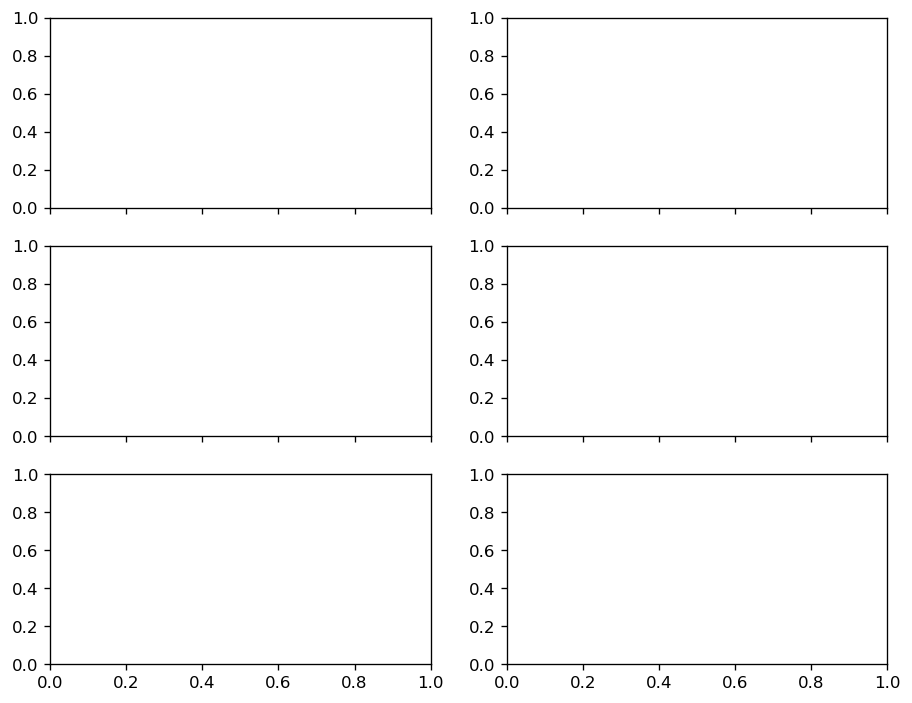

In [116]:
# The Genuine Series  
fig, axes = plt.subplots(3, 2, sharex = True)  
axes[0, 0].plot(mydata.value); axes[0, 0].set_title('The Genuine Series')  
plot_acf(df.value, ax = axes[0, 1])  

In [99]:
# Order of Differencing: First  
axes[1, 0].plot(mydata.value.diff()); axes[1, 0].set_title('Order of Differencing: First')  
plot_acf(df.value.diff().dropna(), ax = axes[1, 1])  

ValueError: setting an array element with a sequence.

In [58]:
# Order of Differencing: Second  
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('Order of Differencing: Second')  
plot_acf(df.value.diff().diff().dropna(), ax = axes[2, 1])  
plt.show()  


AttributeError: 'DataFrame' object has no attribute 'value'

In [100]:
# Determine the differencing above. Weak/ strong stationarity? 
# Next, looking at how to make the data stationary via 3 tests. 

In [106]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 224.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 209.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 288.6 kB/s eta 0:00:0000:0100:01


In [37]:
from pmdarima.arima.utils import ndiffs  
import pandas as pd
import os

In [38]:
df = pd.read_csv(pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)
X = df.value  

SyntaxError: invalid syntax (435811439.py, line 2)

In [119]:
# Augmented Dickey Fuller Test  
adftest = ndiffs(df, test = 'adf')  

In [120]:
# KPSS Test  
kpsstest = ndiffs(df, test = 'kpss')  

In [121]:
# PP Test  
pptest = ndiffs(df, test = 'pp')  

In [122]:
print("ADF Test =", adftest)  
print("KPSS Test =", kpsstest)  
print("PP Test =", pptest) 

ADF Test = 0
KPSS Test = 0
PP Test = 0


In [30]:
#Next finding the 'p' term for AR via a partial auocorrelatoin graph

In [31]:
import numpy as np, pandas as pd  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import matplotlib.pyplot as plt  

In [32]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})  

In [35]:
import os

In [36]:
# importing data 
df = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)  

NameError: name 'DATA_DIR' is not defined

ValueError: setting an array element with a sequence.

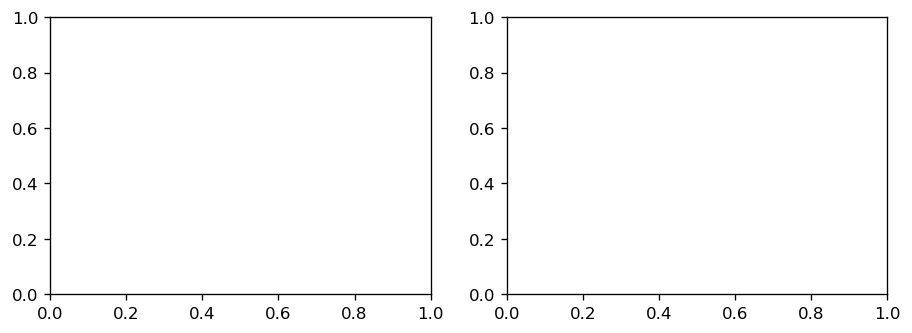

In [130]:
fig, axes = plt.subplots(1, 2, sharex = True)  
axes[0].plot(df.value.diff()); axes[0].set_title('Order of Differencing: First')  
axes[1].set(ylim = (0,5))  
plot_pacf(df.value.diff().dropna(), ax = axes[1])  
plt.show()  

In [131]:
# Look a the blue region to determine if it is useful or not

In [132]:
#Next, finding the 'q' MA 
import numpy as np, pandas as pd  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import matplotlib.pyplot as plt  
  
plt.rcParams.update({'figure.figsize' : (9,3), 'figure.dpi' : 120})  

In [134]:
# importing data  
mydata = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)  

ValueError: setting an array element with a sequence.

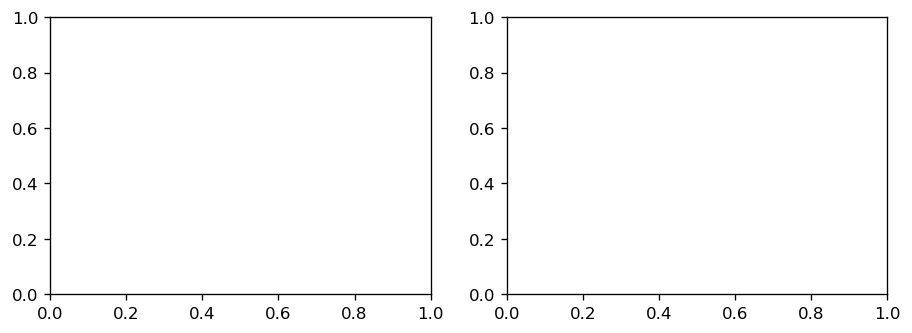

In [135]:
fig, axes = plt.subplots(1, 2, sharex = True)  
axes[0].plot(mydata.value.diff()); axes[0].set_title('Order of Differencing: First')  
axes[1].set(ylim = (0, 1.2))  
plot_acf(mydata.value.diff().dropna(), ax = axes[1])  
plt.show() 

In [136]:
# Looking at the autocorrelation graph, we can determine the number needed for q 


In [137]:
# Now building the ARIMA model 

import numpy as np, pandas as pd  
from statsmodels.tsa.arima_model import ARIMA  

In [139]:
# importing data  
mydata = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)  

In [140]:
# Creating ARIMA model  
# change the () to whatever numbers we get from the results for p,d,q above 
mymodel = ARIMA(mydata.value, order = (1, 1, 2))  
modelfit = mymodel.fit(disp = 0)  
print(modelfit.summary())  

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [141]:
# These are the results. We can alter the output by changing the AIC/ BIC if we have a close call. 

# Now we plot the residuals to ensure that there is no constant mean or varaince to worry about 

In [142]:
import numpy as np, pandas as pd  
from statsmodels.tsa.arima_model import ARIMA  
import matplotlib.pyplot as plt  

In [143]:
plt.rcParams.update({'figure.figsize' : (9,3), 'figure.dpi' : 120})  

In [144]:
# importing data  
mydata = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)  

In [145]:
# Creating ARIMA model  
mymodel = ARIMA(mydata.value, order = (1, 1, 1))  
modelfit = mymodel.fit(disp = 0)  

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [146]:
# Plotting Residual Errors  
myresiduals = pd.DataFrame(modelfit.resid)  
fig, ax = plt.subplots(1,2)  
myresiduals.plot(title = "Residuals", ax = ax[0])  
myresiduals.plot(kind = 'kde', title = 'Density', ax = ax[1])  
plt.show()  

NameError: name 'modelfit' is not defined

In [147]:
# finally, graphing our predicted versus actual values for trend analysis 

In [148]:
import numpy as np, pandas as pd  
from statsmodels.tsa.arima_model import ARIMA  
import matplotlib.pyplot as plt  

In [149]:
plt.rcParams.update({'figure.figsize' : (9,3), 'figure.dpi' : 120})  


In [151]:
# importing data  
mydata = pd.read_csv(os.path.join(DATA_DIR, 'returns.csv'), names = ['value'], header = 0)  

In [152]:
# Creating ARIMA model  
mymodel = ARIMA(mydata.value, order = (1, 1, 1))  
modelfit = mymodel.fit(disp = 0)  

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [153]:
# Actual vs Fitted  
modelfit.plot_predict(dynamic = False)  
plt.show()

NameError: name 'modelfit' is not defined